# 환경설정
## 주요 라이브러리 로딩

In [83]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


## 데이터 준비

In [2]:
!mkdir -p ~/aiffel/medical
!ln -s ~/data/* ~/aiffel/medical

ln: failed to create symbolic link '/aiffel/aiffel/medical/ed_ckpt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train_labels': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/unet_ckpt': File exists


## 데이터셋 분리

In [84]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [85]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [86]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [87]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


## 데이터셋 시각화

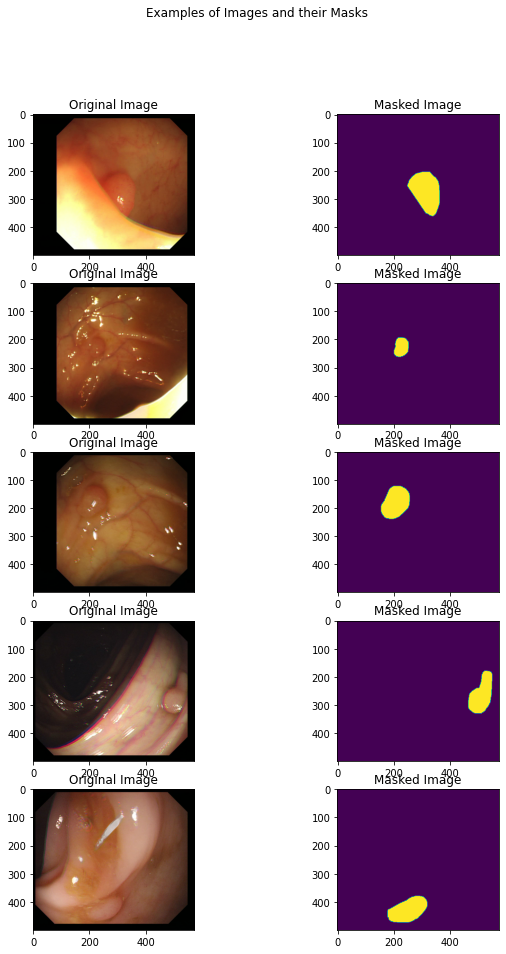

In [7]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2): # process indexes to draw 2-column subplots
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]
    
    original_image = Image.open(x_pathname)

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

# 데이터 파이프라인 설정 및 프로세싱
## 공통 하이퍼파라미터 설정

In [8]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 100

## tf.data를 활용한 입력 파이프라인 설계
### pathname 프로세싱
- byte 형태로 데이터를 로드 후 bmp로 디코딩
- 디코딩된 이미지의 scale과 size를 조절

In [9]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

### 데이터 증강 - 이미지 이동
- 입력이미지와 라벨의 쌍을 동일한 값으로 이동

In [10]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal and/or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

### 데이터 증강 - 이미지 반전
- 50% 확률로 이미지를 좌우 반전

In [11]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

### 데이터 증강 - 종합
- 상기된 개별 데이터 증강 함수를 종합
- resize, hue-delta 역시 적용

In [12]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

## 훈련 및 테스트 데이터셋 설정
- 데이터 증강은 훈련 데이터셋에만 적용

In [13]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

## 훈련 데이터 시각화

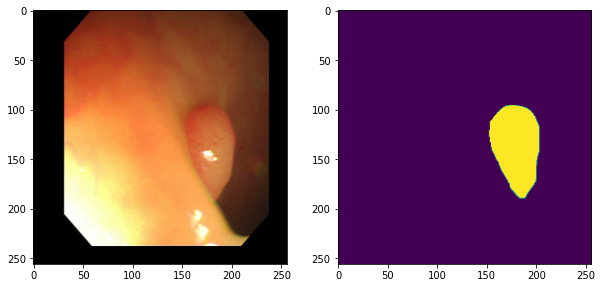

In [15]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

# 모델 설계 및 작성
## Encoder-Decoder 아키텍처
- Encoder를 이용해 우리가 가진 Train data를 작은 차원의 공간에 압축하는 방식으로 동작합니다.
- Decoder는 Encoder가 압축한 데이터들을 우리가 원하는 label 데이터와 같도록 재생성합니다.
- 이렇게 생성된 데이터와 label 간의 차이가 작아지도록 Encoder와 Decoder의 파라미터들이 End-to-End로 학습됩니다.

## Sequential 방식을 활용한 모델 구현
- 모델의 형태가 선형으로 구성되어 Keras의 Sequential API를 사용 가능

### Encoder 작성

In [16]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


### Decoder 작성

In [17]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


### 모델 작성

In [18]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

> 본 프로젝트에서 ed_model은 학습을 진행하지 않으며, 모델 학습에 관련된 내용은 U-Net 아키텍처에 대해서만 진행합니다.<br>
> 그 대신, 성과 평가 단락에서 ed_모델에 대한 평가는 기존 학습된 모델의 가중치를 불러와 진행합니다.

## U-Net 아키텍쳐
- 원본 U-Net과의 차이점: Padding을 zero가 아닌 same으로 설정
- 이를 통해 Encoder-Decoder의 대응하는 레이어 형태를 동일하게 구현할 수 있음
- 이는 성능상 큰 영향을 주지 않으면서 구현과 유지보수를 용이하게 함

### Model Subclassing을 활용한 구현
- 모델의 형태가 선형으로 구성되지 않아 Sequential API를 사용할 수 없음

In [88]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [89]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [90]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [22]:
unet_model = UNet()

## 메트릭과 손실함수 정의
- binay Cross-Entropy 함수와 dice_loss 함수를 같이 사용하여 평균 IoU가 높아지도록 학습

In [91]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

# Dice_Coeff가 낮을수록 Dice_Loss가 높아지도록 구성

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [92]:
# binary Cross-Entropy와 Dice Loss를 합산

def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + dice_loss(y_true, y_pred)
    return loss

In [93]:
# Keras 내장 옵티마이저와 기본 학습률 사용

optimizer = tf.keras.optimizers.Adam()

## 모델 설정
- Encoder-Decoder 모델을 설정하기 위해선 아래 블록을 실행하세요.

In [26]:
print('select the Encoder-Decoder model')
model = ed_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

select the Encoder-Decoder model


- U-Net 모델을 설정하기 위해선 아래 블록을 실행하세요.

In [27]:
print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


In [28]:
unet_model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = unet_model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

model.summary()

(8, 256, 256, 1)
Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple       

## Callbacks 정의
- ModelCheckpoint callback 함수는 모델 학습간 특정 feature를 모니터링하다 기준점을 넘으면 모델 파라미터를 저장하는 역할을 합니다.
- LearningRateScheduler callback 함수는 학습을 진행하며, 주어진 인자의 값을 이용해 Learning rate를 조절해주는 함수입니다.
- cos_decay는 cos 함수의 모양으로 Learning rate를 조절해 주는 learning rate decay 구현입니다.

In [94]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)

lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

es_callback = tf.keras.callbacks.EarlyStopping(patience = 5)

# 모델 학습 및 테스트

In [ ]:
# 모델의 예측 이미지를 출력하는 함수 설정
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

# 모델 훈련
history = model.fit(train_dataset, # 학습 데이터의 수가 부족하여 val_set을 분리하지 않음
                    epochs=max_epochs,
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset, # 학습 데이터의 수가 부족하여 Test_set을 Val_set으로 사용
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 36s 840ms/step - loss: 1.1524 - dice_loss: 0.7430 - val_loss: 33774.7422 - val_dice_loss: 0.8985
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009997532, shape=(), dtype=float32).
30/30 [==============================] - 27s 843ms/step - loss: 0.9374 - dice_loss: 0.6998 - val_loss: 115.7107 - val_dice_loss: 1.0000
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
30/30 [==============================] - 27s 865ms/step - loss: 0.8990 - dice_loss: 0.6806 - val_loss: 4.9974 - val_dice_loss: 1.0000
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.000997781, shape=(), dtype=float32).
30/30 [==============================] - 28s 887ms/step - loss: 0.9022 - dice_loss: 0.6755 - val_loss: 10.53

30/30 [==============================] - 28s 882ms/step - loss: 0.0959 - dice_loss: 0.0701 - val_loss: 0.1690 - val_dice_loss: 0.1203
Epoch 65/100

Epoch 00065: LearningRateScheduler setting learning rate to tf.Tensor(0.00028711034, shape=(), dtype=float32).
30/30 [==============================] - 28s 883ms/step - loss: 0.0864 - dice_loss: 0.0620 - val_loss: 0.1531 - val_dice_loss: 0.1103
Epoch 66/100

Epoch 00066: LearningRateScheduler setting learning rate to tf.Tensor(0.00027300484, shape=(), dtype=float32).
30/30 [==============================] - 28s 887ms/step - loss: 0.0866 - dice_loss: 0.0629 - val_loss: 0.1477 - val_dice_loss: 0.1060
Epoch 67/100

Epoch 00067: LearningRateScheduler setting learning rate to tf.Tensor(0.0002591231, shape=(), dtype=float32).
30/30 [==============================] - 28s 891ms/step - loss: 0.0938 - dice_loss: 0.0691 - val_loss: 0.1606 - val_dice_loss: 0.1170
Epoch 68/100

Epoch 00068: LearningRateScheduler setting learning rate to tf.Tensor(0.0002

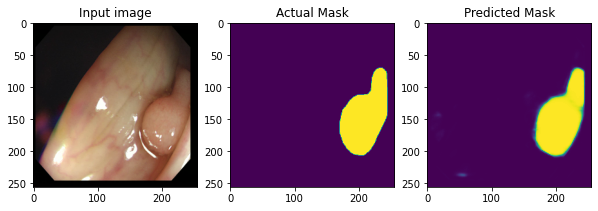

In [40]:
# 학습 후 샘플 이미지 출력
print_images()

## 손실함수 시각화

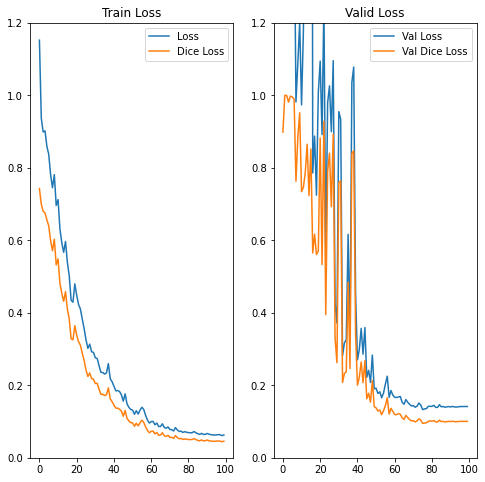

In [42]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.ylim(0, 1.2)
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.ylim(0, 1.2)
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [43]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요

# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
# checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')


# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

## 테스트 데이터셋 평가
- 테스트 데이터셋에 대해 Mean IoU를 계산하여 모델의 성능을 정량적으로 평가합니다.
- Mean IoU란 각 이미지의 IoU(교집합 면적/합집합 면적) 값을 평균낸 지표입니다.

In [121]:
## Define mean_iou function
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

## Define print function
def print_images(model):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

### ED 모델 성능 정량지표 확인 및 시각화

In [118]:
checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
ed_model.load_weights(checkpoint_dir)

mean = []

for images, labels in test_dataset:
    predictions = ed_model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.6673271373465169


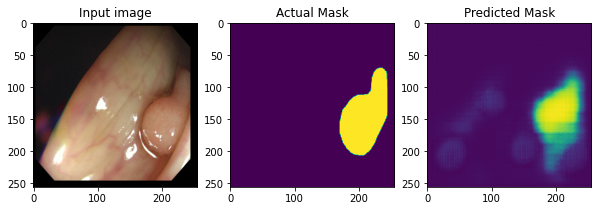

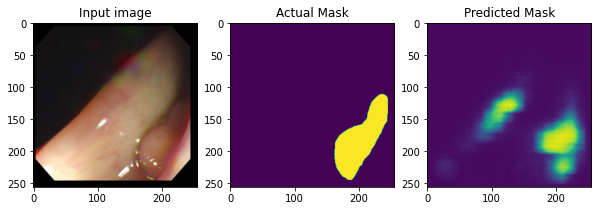

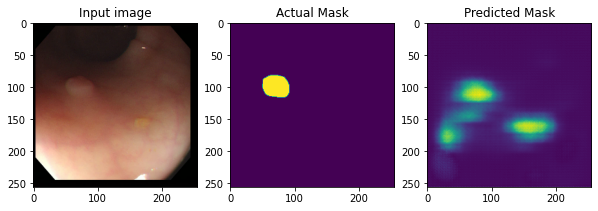

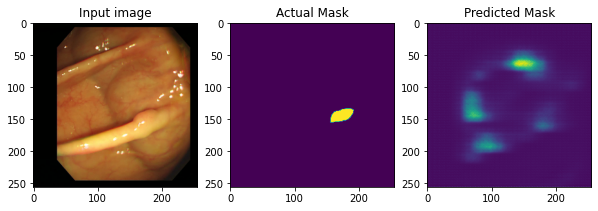

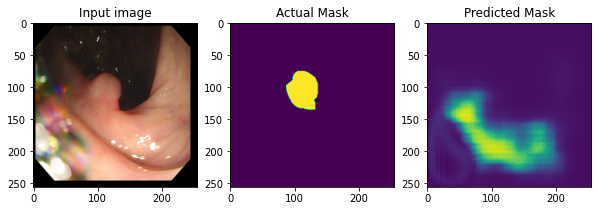

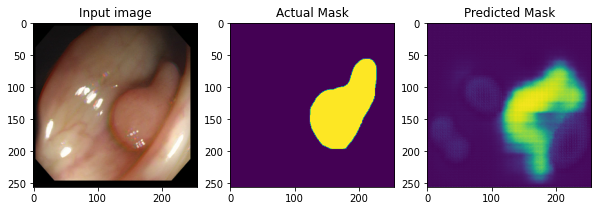

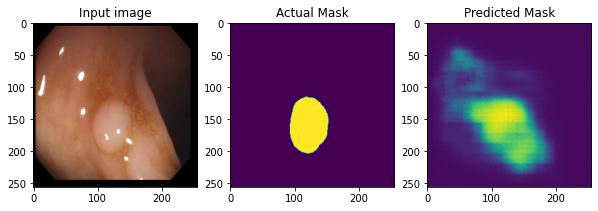

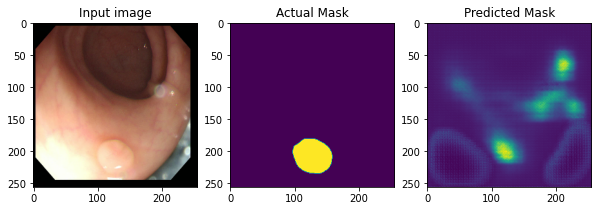

In [122]:
print_images(ed_model)

### U-Net 모델 성능 정량지표 확인 및 시각화

In [126]:
checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/unet_model')
unet_model.load_weights(checkpoint_dir)

mean = []

for images, labels in test_dataset:
    predictions = unet_model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.8980427470644636


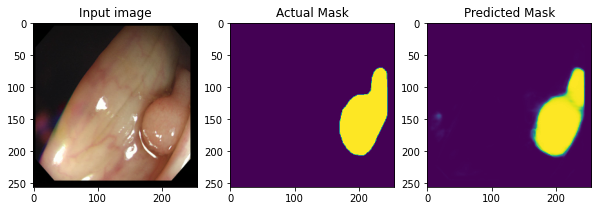

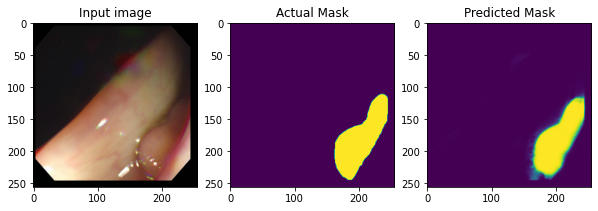

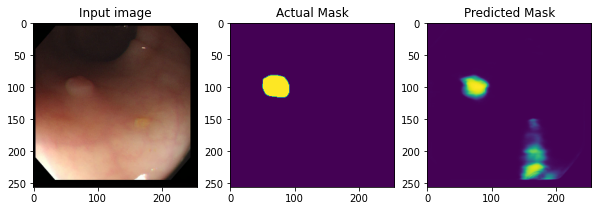

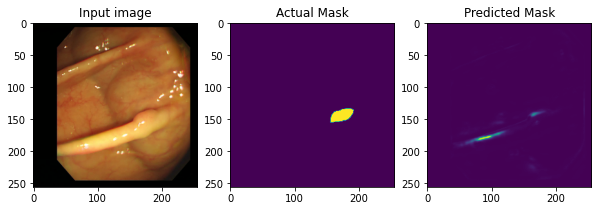

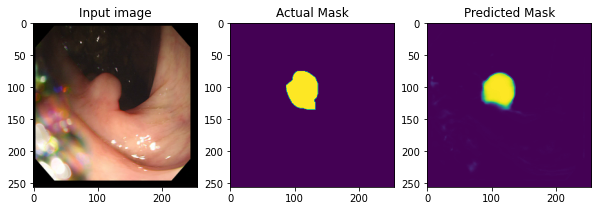

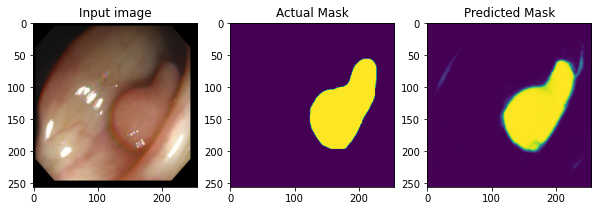

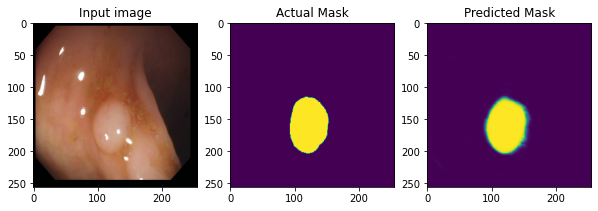

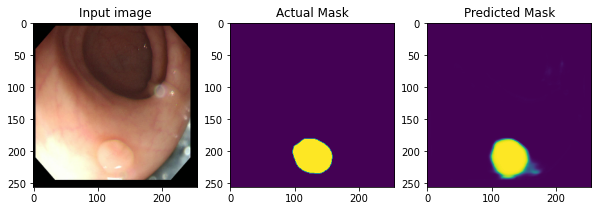

In [124]:
print_images(unet_model)

# 프로젝트: U-Net 아키텍처 및 성능 개선
- 주로 U-Net모델의 인코더를 기존의 Pretrained Model을 사용하는 방식으로 진행

In [51]:
# 주요 라이브러리 버전 확인
import tensorflow
import sklearn
import numpy

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

2.6.0
1.0
1.21.4


## 데이터셋: 기존 데이터셋(Giana)을 동일하게 활용

## Pretrained Model을 활용한 U-Net 모델 구성

### vgg16 활용

In [52]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

58900480/58889256 [==============================] - 0s 0us/step


[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,


In [95]:
# vgg16 모델을 Encoder로 활용한 U-Net 클래스 정의

class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

In [96]:
# 모델 정의 및 컴파일
vgg16_unet = Vgg16UNet()
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/vgg16_unet_model')

vgg16_unet.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])

In [106]:
# 모델 훈련
history = vgg16_unet.fit(train_dataset, # 학습 데이터의 수가 부족하여 val_set을 분리하지 않음
                    epochs=max_epochs,
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset, # 학습 데이터의 수가 부족하여 Test_set을 Val_set으로 사용
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 18s 539ms/step - loss: 0.2186 - dice_loss: 0.1621 - val_loss: 0.2609 - val_dice_loss: 0.1852
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009997532, shape=(), dtype=float32).
30/30 [==============================] - 18s 549ms/step - loss: 0.2014 - dice_loss: 0.1487 - val_loss: 0.3138 - val_dice_loss: 0.2157
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
30/30 [==============================] - 18s 551ms/step - loss: 0.1900 - dice_loss: 0.1403 - val_loss: 0.2197 - val_dice_loss: 0.1576
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.000997781, shape=(), dtype=float32).
30/30 [==============================] - 18s 559ms/step - loss: 0.1888 - dice_loss: 0.1391 - val_loss: 0.2446 - va

30/30 [==============================] - 19s 585ms/step - loss: 0.0616 - dice_loss: 0.0448 - val_loss: 0.1270 - val_dice_loss: 0.0894
Epoch 33/100

Epoch 00033: LearningRateScheduler setting learning rate to tf.Tensor(0.00076791336, shape=(), dtype=float32).
30/30 [==============================] - 19s 581ms/step - loss: 0.0657 - dice_loss: 0.0480 - val_loss: 0.1325 - val_dice_loss: 0.0933
Epoch 34/100

Epoch 00034: LearningRateScheduler setting learning rate to tf.Tensor(0.0007545207, shape=(), dtype=float32).
30/30 [==============================] - 19s 595ms/step - loss: 0.0603 - dice_loss: 0.0440 - val_loss: 0.1390 - val_dice_loss: 0.1000
Epoch 35/100

Epoch 00035: LearningRateScheduler setting learning rate to tf.Tensor(0.0007408768, shape=(), dtype=float32).
30/30 [==============================] - 19s 588ms/step - loss: 0.0665 - dice_loss: 0.0486 - val_loss: 0.1351 - val_dice_loss: 0.0975
Epoch 36/100

Epoch 00036: LearningRateScheduler setting learning rate to tf.Tensor(0.00072

30/30 [==============================] - 19s 587ms/step - loss: 0.0394 - dice_loss: 0.0288 - val_loss: 0.1256 - val_dice_loss: 0.0876
Epoch 65/100

Epoch 00065: LearningRateScheduler setting learning rate to tf.Tensor(0.00028711034, shape=(), dtype=float32).
30/30 [==============================] - 19s 587ms/step - loss: 0.0389 - dice_loss: 0.0284 - val_loss: 0.1260 - val_dice_loss: 0.0887
Epoch 66/100

Epoch 00066: LearningRateScheduler setting learning rate to tf.Tensor(0.00027300484, shape=(), dtype=float32).
30/30 [==============================] - 19s 587ms/step - loss: 0.0392 - dice_loss: 0.0285 - val_loss: 0.1185 - val_dice_loss: 0.0835
Epoch 67/100

Epoch 00067: LearningRateScheduler setting learning rate to tf.Tensor(0.0002591231, shape=(), dtype=float32).
30/30 [==============================] - 19s 586ms/step - loss: 0.0393 - dice_loss: 0.0287 - val_loss: 0.1169 - val_dice_loss: 0.0826
Epoch 68/100

Epoch 00068: LearningRateScheduler setting learning rate to tf.Tensor(0.0002

30/30 [==============================] - 19s 585ms/step - loss: 0.0333 - dice_loss: 0.0245 - val_loss: 0.1244 - val_dice_loss: 0.0863
Epoch 97/100

Epoch 00097: LearningRateScheduler setting learning rate to tf.Tensor(3.9426386e-06, shape=(), dtype=float32).
30/30 [==============================] - 19s 586ms/step - loss: 0.0334 - dice_loss: 0.0246 - val_loss: 0.1246 - val_dice_loss: 0.0864
Epoch 98/100

Epoch 00098: LearningRateScheduler setting learning rate to tf.Tensor(2.2189915e-06, shape=(), dtype=float32).
30/30 [==============================] - 19s 586ms/step - loss: 0.0330 - dice_loss: 0.0241 - val_loss: 0.1248 - val_dice_loss: 0.0865
Epoch 99/100

Epoch 00099: LearningRateScheduler setting learning rate to tf.Tensor(9.866358e-07, shape=(), dtype=float32).
30/30 [==============================] - 19s 586ms/step - loss: 0.0317 - dice_loss: 0.0229 - val_loss: 0.1246 - val_dice_loss: 0.0864
Epoch 100/100

Epoch 00100: LearningRateScheduler setting learning rate to tf.Tensor(2.467

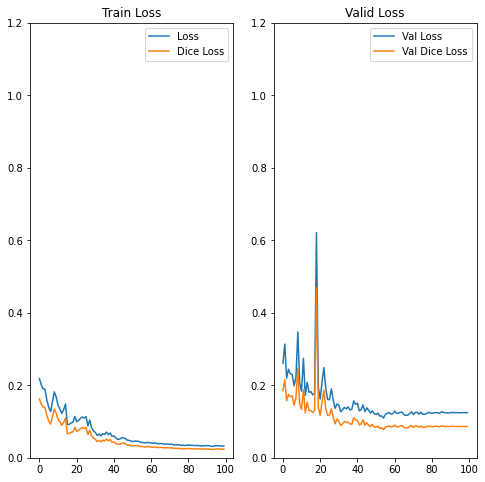

In [109]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.ylim(0, 1.2)
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.ylim(0, 1.2)
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

### vgg16-UNet 모델 성능 정량지표 확인 및 시각화

In [111]:
mean = []

for images, labels in test_dataset:
    predictions = vgg16_unet(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.905624106115193


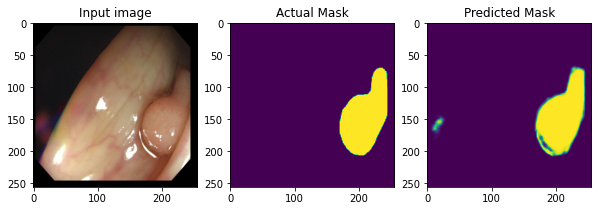

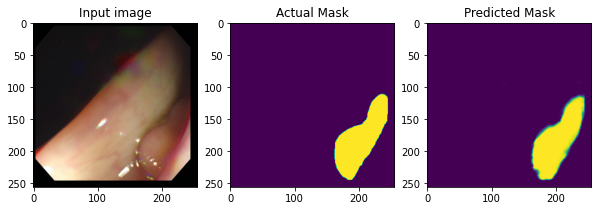

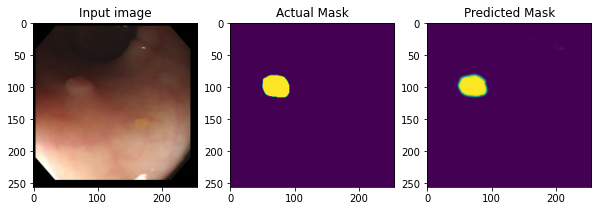

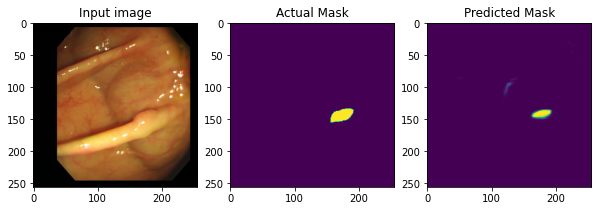

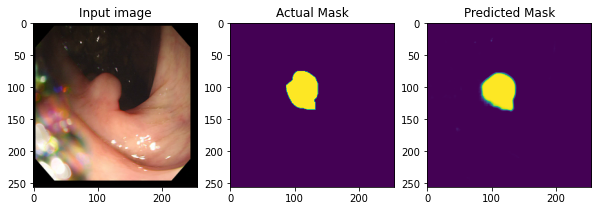

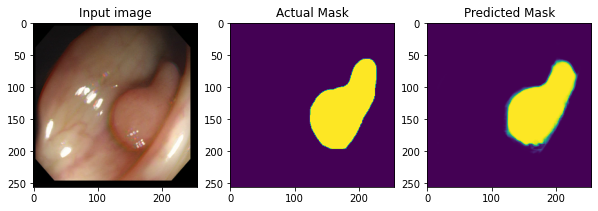

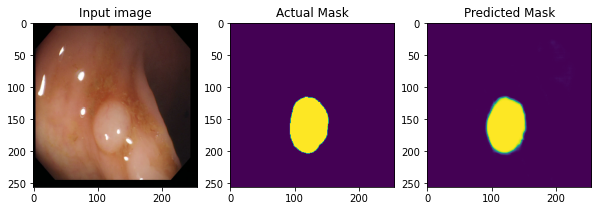

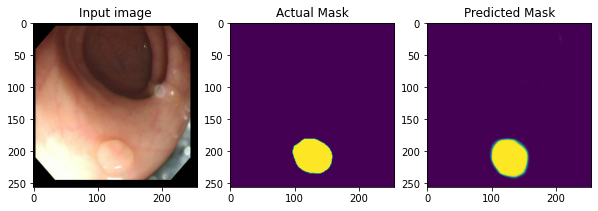

In [127]:
print_images(vgg16_unet)

## ED 모델과 기본 U-Net의 결과 비교
- ED 모델의 mIoU는 약 0.68인데 비해 기본 U-Net의 mIoU는 0.89로 매우 큰 차이를 보임
- 이는 U-Net 아키텍처의 우위에 의한 것으로 해석할 수 있음

## 기본 U-Net과 vgg16 U-Net의 결과 비교
- 기본 U-Net의 mIoU는 약 0.89인 것에 반해, vgg16을 활용한 U-Net의 경우 약 0.91로 소폭 증가함
- history를 시각화한 것을 참조할 때, 최소 두 가지의 눈에 띄는 개선점이 발견됨
    - 이미 훈련된 인코더를 활용하는 만큼, 기본 모델과 비교하여 훈련 초기부터 매우 월등한 성능을 보임
    - 훈련이 최종 완료된 후의 성능 역시 기본 모델과 비교하여 우위인 것으로 확인됨
- Val_loss의 개선이 더 이상 이루어지지 않는 지점(≒overfitting) 역시 조기에 발생하여 훈련비용 감소 역시 기대됨
- 그러나 학습 초반의 성능상 우위에 비해 학습이 완료된 후의 차이는 두드러지지 않는 것을 확인할 수 있음